## Notebook summary

In this notebook we will:

⚡ Establish access to a hosted Redshift database instance

⚡ Create tables fed from data in S3 buckets

⚡ Use SQL within Jupyter notebooks through `JupySQL` to create tables, clean the data, and merge the tables. 

⚡ Visualize the resulting merged table with `seaborn`

⚡ Set up a classification model for the data with `sklearn` (`sklearn.ensemble.RandomForestClassifier`) 

⚡ Evaluate the model's results using `sklearn.metrics `

## What is JupySQL

JupySQL is an open source project whose goal is to enable you to run SQL and plot large datasets in Jupyter via a `%sql`, `%%sql`, and `%sqlplot` magics. 

JupySQL is compatible with all major databases (e.g., PostgreSQL, MySQL, SQL Server), data warehouses (e.g., Snowflake, BigQuery, Redshift), and embedded engines (SQLite, and DuckDB).

## What is Amazon Redshift? 

Amazon Redshift uses SQL to analyze structured and semi-structured data across data warehouses, operational databases, and data lakes, using AWS-designed hardware and machine learning to deliver the best price performance at any scale.
![](redshift.png)

## Goal

Example: https://github.com/aws-samples/getting-started-with-amazon-redshift-data-api/blob/main/use-cases/sagemaker-notebook-redshift-ml/redshift_ml_with_data_api.ipynb

⚡ Enable seamless integration to perform EDA within local Jupyter notebooks

⚡ Remove the need to execute outside scripts within Jupyter notebooks when setting up the tables

⚡ Automatically convert SQL query results to `pandas` or `polars` dataframes for further data analysis

Further documentation: https://aws.amazon.com/blogs/machine-learning/build-regression-models-with-amazon-redshift-ml/

## Pre-requisites

1️⃣ AWS Redshift username and password

2️⃣ AWS Redshift host

3️⃣ S3 bucket(s) with data

4️⃣Jupyter notebooks + the JupySQL extension

## Part I: Setting up access to the data, and setting up a database and tables.

## Dependencies

In [ ]:
%pip install jupysql --upgrade sqlalchemy-redshift redshift-connector "sqlalchemy<2" --quiet

## Modules

In [1]:
from dotenv import load_dotenv
from os import environ
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import os

## Access your credentials securely

You can create a `.env` file that looks as follows

```bash
REDSHIFT_USERNAME = "my-username"
REDSHIFT_PASSWORD = "my-password"
REDSHIFT_HOST = "my-workgroup.my-account-id.us-east-1.redshift-serverless.amazonaws.com"
IAM_role = 'arn:aws:iam::my-account-id:role/my-redshift-s3-space'
```

In [2]:
# Load environment variables
load_dotenv(".env")

user = os.environ.get("REDSHIFT_USERNAME")
password = os.environ.get("REDSHIFT_PASSWORD")
host = os.environ.get("REDSHIFT_HOST")
iamrole = os.environ.get("IAM_role")

## Form the connection string

In [3]:
url = URL.create(
    drivername="redshift+redshift_connector",
    username=user,
    password=password,
    host=host,
    port=5439,
    database="dev",
)

engine = create_engine(url)

## Load the JupySQL extension

In [47]:
%reload_ext sql

Found pyproject.toml from '/Users/macpro/Documents/GitHub/sql/docs/video-material/redshift'

Settings changed:

Config,value
displaycon,False
feedback,True
autopandas,True
named_parameters,True


## Use the engine to initialize access to our Redshift via the alias `redshift`

In [5]:
%sql engine --alias redshift

## Create table `ridership` from data in S3 bucket

In [6]:
%%sql
DROP TABLE IF EXISTS ridership CASCADE;

CREATE TABLE IF NOT EXISTS ridership
( trip_id               INT, 
 trip_duration_seconds INT, 
 trip_start_time       timestamp,
 trip_stop_time        timestamp,
 from_station_name     VARCHAR(50),
 to_station_name       VARCHAR(50),
 from_station_id       SMALLINT,
 to_station_id         SMALLINT,
 user_type             VARCHAR(20));



COPY ridership FROM 
's3://redshift-ml-bikesharing-data/bike-sharing-data/ridership/'
IAM_ROLE '{{iamrole}}'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;



""


## Verifying `ridership` table

In [7]:
%sqlcmd columns -t ridership 


name,type,nullable,default,autoincrement,comment,info
trip_id,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_duration_seconds,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_start_time,TIMESTAMP,True,None,False,None,{'encode': 'az64'}
trip_stop_time,TIMESTAMP,True,None,False,None,{'encode': 'az64'}
from_station_name,VARCHAR(50),True,None,False,None,{'encode': 'lzo'}
to_station_name,VARCHAR(50),True,None,False,None,{'encode': 'lzo'}
from_station_id,SMALLINT,True,None,False,None,{'encode': 'az64'}
to_station_id,SMALLINT,True,None,False,None,{'encode': 'az64'}
user_type,VARCHAR(20),True,None,False,None,{'encode': 'lzo'}


In [8]:
%sqlcmd profile --table ridership 

,trip_id,trip_duration_seconds,trip_start_time,trip_stop_time,from_station_name,to_station_name,from_station_id,to_station_id,user_type
count,3415315,3415315,3415315,3415315,3415315,3415315,2388423,2388423,3415315
unique,3415315,21278,965559,959085,411,411,359,359,4
mean,2644335.0000,986.0000,nan,nan,nan,nan,7123.0000,7122.0000,nan
min,712382,1,nan,nan,nan,nan,7000,7000,nan
max,4581277,6382030,nan,nan,nan,nan,7391,7391,nan


## Create table `weather` from data in S3 bucket

In [9]:
%%sql
DROP TABLE IF EXISTS weather CASCADE;

CREATE TABLE IF NOT EXISTS weather
( longitude_x         DECIMAL(5,2),
 latitude_y          DECIMAL(5,2), 
 station_name        VARCHAR(20),
 climate_id          BIGINT,
 datetime_utc        TIMESTAMP,
 weather_year        SMALLINT,
 weather_month       SMALLINT,
 weather_day         SMALLINT,
 time_utc            VARCHAR(5),
 temp_c              DECIMAL(5,2),
 temp_flag           VARCHAR(1),
 dew_point_temp_c    DECIMAL(5,2),
 dew_point_temp_flag VARCHAR(1),
 rel_hum             SMALLINT,
 rel_hum_flag        VARCHAR(1),
 precip_amount_mm    DECIMAL(5,2),
 precip_amount_flag  VARCHAR(1),
 wind_dir_10s_deg    VARCHAR(10),
 wind_dir_flag       VARCHAR(1),
 wind_spd_kmh        VARCHAR(10),
 wind_spd_flag       VARCHAR(1),
 visibility_km       VARCHAR(10),
 visibility_flag     VARCHAR(1),
 stn_press_kpa       DECIMAL(5,2),
 stn_press_flag      VARCHAR(1),
 hmdx                SMALLINT,
 hmdx_flag           VARCHAR(1),
 wind_chill          VARCHAR(10),
 wind_chill_flag     VARCHAR(1),
 weather             VARCHAR(10));


COPY weather FROM
's3://redshift-ml-bikesharing-data/bike-sharing-data/weather/'
IAM_ROLE '{{iamrole}}'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;


""


## Verifying `weather` table

In [10]:
%sqlcmd columns -t weather 


name,type,nullable,default,autoincrement,comment,info
longitude_x,"NUMERIC(5, 2)",True,None,False,None,{'encode': 'az64'}
latitude_y,"NUMERIC(5, 2)",True,None,False,None,{'encode': 'az64'}
station_name,VARCHAR(20),True,None,False,None,{'encode': 'lzo'}
climate_id,BIGINT,True,None,False,None,{'encode': 'az64'}
datetime_utc,TIMESTAMP,True,None,False,None,{'encode': 'az64'}
weather_year,SMALLINT,True,None,False,None,{'encode': 'az64'}
weather_month,SMALLINT,True,None,False,None,{'encode': 'az64'}
weather_day,SMALLINT,True,None,False,None,{'encode': 'az64'}
time_utc,VARCHAR(5),True,None,False,None,{'encode': 'lzo'}
temp_c,"NUMERIC(5, 2)",True,None,False,None,{'encode': 'az64'}


In [11]:
%sqlcmd profile --table weather 


,longitude_x,latitude_y,station_name,climate_id,datetime_utc,weather_year,weather_month,weather_day,time_utc,temp_c,temp_flag,dew_point_temp_c,dew_point_temp_flag,rel_hum,rel_hum_flag,precip_amount_mm,precip_amount_flag,wind_dir_10s_deg,wind_dir_flag,wind_spd_kmh,wind_spd_flag,visibility_km,visibility_flag,stn_press_kpa,stn_press_flag,hmdx,hmdx_flag,wind_chill,wind_chill_flag,weather
count,17408,17408,17408,17408,17408,17408,17408,17408,17408,17408,17408,17408,17408,17408,17408,17311,17408,17408,17408,17408,17408,17408,17408,17408,17408,3080,17408,17408,17408,17408
unique,1,1,1,1,17408,2,12,31,24,520,1,487,1,86,1,79,2,1,1,1,1,1,1,523,1,17,1,1,1,1
mean,nan,nan,nan,6158355.0000,nan,2017.0000,6.0000,15.0000,nan,nan,nan,nan,nan,65.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,nan,nan,nan,6158355,nan,2017,1,1,nan,nan,nan,nan,nan,13,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
max,nan,nan,nan,6158355,nan,2018,12,31,nan,nan,nan,nan,nan,98,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Create table `holiday` from data in S3 bucket

In [12]:
%%sql
DROP TABLE IF EXISTS holiday CASCADE;

CREATE TABLE IF NOT EXISTS holiday
( holiday_date  DATE,
 description VARCHAR(100));


COPY holiday FROM
's3://redshift-ml-bikesharing-data/bike-sharing-data/holiday/'
IAM_ROLE '{{iamrole}}'
FORMAT csv IGNOREHEADER 1 DATEFORMAT 'auto' TIMEFORMAT 'auto' REGION 'us-west-2' gzip;


""


## Verifying `holiday` table


In [13]:
%sqlcmd columns -t holiday 

name,type,nullable,default,autoincrement,comment,info
holiday_date,DATE,True,None,False,None,{'encode': 'az64'}
description,VARCHAR(100),True,None,False,None,{'encode': 'lzo'}


In [14]:
%sqlcmd profile --table holiday 

,holiday_date,description
count,195,195
unique,195,12
min,nan,nan
max,nan,nan


## Create table `ridership_view` - data clean up

* Transform the records to all be in the local time zone. The data before July 2017 was provided in UTC, whereas all data after that was in Toronto’s local time zone, EST.

* Discard trips with a duration under 60 seconds.

* Discard trips with a duration longer than a day.

* Aggregate data to an hourly basis (rather than minute-level granularity) for better generalization.

*
Break down the trip date column into day, month, year, quarter, month_week, and week_day for better correlation with the number of rides.

In [39]:
%%sql
CREATE OR REPLACE VIEW ridership_view AS
SELECT
    trip_time, 
    trip_count,
    TO_CHAR(trip_time,'hh24') ::INT trip_hour,
    TO_CHAR(trip_time, 'dd') :: INT trip_day,
    TO_CHAR(trip_time, 'mm') :: INT trip_month,
    TO_CHAR(trip_time, 'yy') :: INT trip_year,
    TO_CHAR(trip_time, 'q') :: INT trip_quarter,
    TO_CHAR(trip_time, 'w') :: INT trip_month_week,
    TO_CHAR(trip_time, 'd') :: INT trip_week_day
FROM  
    (SELECT  
         CASE
           WHEN TRUNC(r.trip_start_time) < '2017-07-01'::DATE
           THEN CONVERT_TIMEZONE('US/Eastern', DATE_TRUNC('hour',r.trip_start_time))
           ELSE DATE_TRUNC('hour',r.trip_start_time)
         END trip_time, COUNT(1) trip_count
     FROM    
         ridership r
     WHERE    r.trip_duration_seconds BETWEEN 60 AND 60 * 60 * 24
     GROUP BY
         1);

""


## Create table `weather_view` - data clean up

* Transform the records from UTC to US/Eastern time zone.
* Aggregate the data to an hourly basis for better generalization.
* Because the majority of the attributes like visibility_km and wind_chill are empty in this dataset, we only use temp_c and precip_amount_mm columns for our model.

In [44]:
%%sql
CREATE OR REPLACE VIEW weather_view AS
SELECT  
    CONVERT_TIMEZONE('US/Eastern', 
      DATE_TRUNC('hour',datetime_utc)) daytime, 
        ROUND(AVG(temp_c)) temp_c, 
        ROUND(AVG(precip_amount_mm)) precip_amount_mm
FROM weather
GROUP BY 1;

""


## Verifying ridership_view table


In [48]:
%sqlcmd columns -t weather_view


name,type,nullable,default,autoincrement,comment,info
daytime,TIMESTAMP,True,None,False,None,{}
temp_c,"NUMERIC(37, 0)",True,None,False,None,{}
precip_amount_mm,"NUMERIC(37, 0)",True,None,False,None,{}


In [46]:
%sqlcmd profile --table ridership_view 

,trip_time,trip_count,trip_hour,trip_day,trip_month,trip_year,trip_quarter,trip_month_week,trip_week_day
count,17420,17420,17420,17420,17420,17420,17420,17420,17420
unique,17420,1066,24,31,12,3,4,5,7
mean,nan,194.0000,11.0000,15.0000,6.0000,17.0000,2.0000,2.0000,3.0000
min,nan,1,0,1,1,16,1,1,1
max,nan,1602,23,31,12,18,4,5,7


## Merging tables as `trip_data`

In [18]:
%%sql
DROP TABLE IF EXISTS trip_data CASCADE;
DROP TABLE IF EXISTS trip_data;
CREATE TABLE trip_data AS 
SELECT         
    r.trip_time,
    r.trip_count,
    r.trip_hour,
    r.trip_day,
    r.trip_month,
    r.trip_year,
    r.trip_quarter,
    r.trip_month_week,
    r.trip_week_day,
    w.temp_c,
    w.precip_amount_mm,
    CASE
        WHEN h.holiday_date IS NOT NULL THEN 1
        WHEN TO_CHAR(r.trip_time,'D')::INT IN (1,7) THEN 1
        ELSE 0
    END AS is_holiday,
    ROW_NUMBER() OVER (ORDER BY RANDOM()) AS serial_number 
FROM           
  ridership_view r
JOIN weather_view w
  ON ( r.trip_time = w.daytime )
LEFT OUTER JOIN holiday h
  ON ( TRUNC(r.trip_time) = h.holiday_date );


""


## Verifying table `trip_data`

In [19]:
%sqlcmd columns -t trip_data 


name,type,nullable,default,autoincrement,comment,info
trip_time,TIMESTAMP,True,None,False,None,{'encode': 'az64'}
trip_count,BIGINT,True,None,False,None,{'encode': 'az64'}
trip_hour,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_day,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_month,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_year,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_quarter,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_month_week,INTEGER,True,None,False,None,{'encode': 'az64'}
trip_week_day,INTEGER,True,None,False,None,{'encode': 'az64'}
temp_c,"NUMERIC(37, 0)",True,None,False,None,{'encode': 'az64'}


In [20]:
%sqlcmd profile --table trip_data 

,trip_time,trip_count,trip_hour,trip_day,trip_month,trip_year,trip_quarter,trip_month_week,trip_week_day,temp_c,precip_amount_mm,is_holiday,serial_number
count,17306,17306,17306,17306,17306,17306,17306,17306,17306,17306,17209,17306,17306
unique,17306,1066,24,31,12,3,4,5,7,56,19,2,17306
mean,nan,194.0000,11.0000,15.0000,6.0000,17.0000,2.0000,2.0000,3.0000,nan,nan,0.0000,8653.0000
min,nan,1,0,1,1,16,1,1,1,nan,nan,0,1
max,nan,1602,23,31,12,18,4,5,7,nan,nan,1,17306


## Part II: Exploratory data analysis and initial model

## Wrangle and Visualize data

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

## Remember our configuration

In [24]:
%reload_ext sql

Found pyproject.toml from '/Users/macpro/Documents/GitHub/sql/docs/video-material/redshift'

Settings changed:

Config,value
displaycon,False
feedback,True
autopandas,True
named_parameters,True


In [49]:
result = %sql select round(trip_count/100) AS rounded_trips, * from trip_data
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17306 entries, 0 to 17305
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rounded_trips     17306 non-null  float64       
 1   trip_time         17306 non-null  datetime64[ns]
 2   trip_count        17306 non-null  int64         
 3   trip_hour         17306 non-null  int64         
 4   trip_day          17306 non-null  int64         
 5   trip_month        17306 non-null  int64         
 6   trip_year         17306 non-null  int64         
 7   trip_quarter      17306 non-null  int64         
 8   trip_month_week   17306 non-null  int64         
 9   trip_week_day     17306 non-null  int64         
 10  temp_c            17306 non-null  object        
 11  precip_amount_mm  17209 non-null  object        
 12  is_holiday        17306 non-null  int64         
 13  serial_number     17306 non-null  int64         
dtypes: datetime64[ns](1), 

In [26]:
print(result.isna().sum())
result.dropna(subset=['precip_amount_mm'], inplace=True)

rounded_trips        0
trip_time            0
trip_count           0
trip_hour            0
trip_day             0
trip_month           0
trip_year            0
trip_quarter         0
trip_month_week      0
trip_week_day        0
temp_c               0
precip_amount_mm    97
is_holiday           0
serial_number        0
dtype: int64


## Visualizing data 

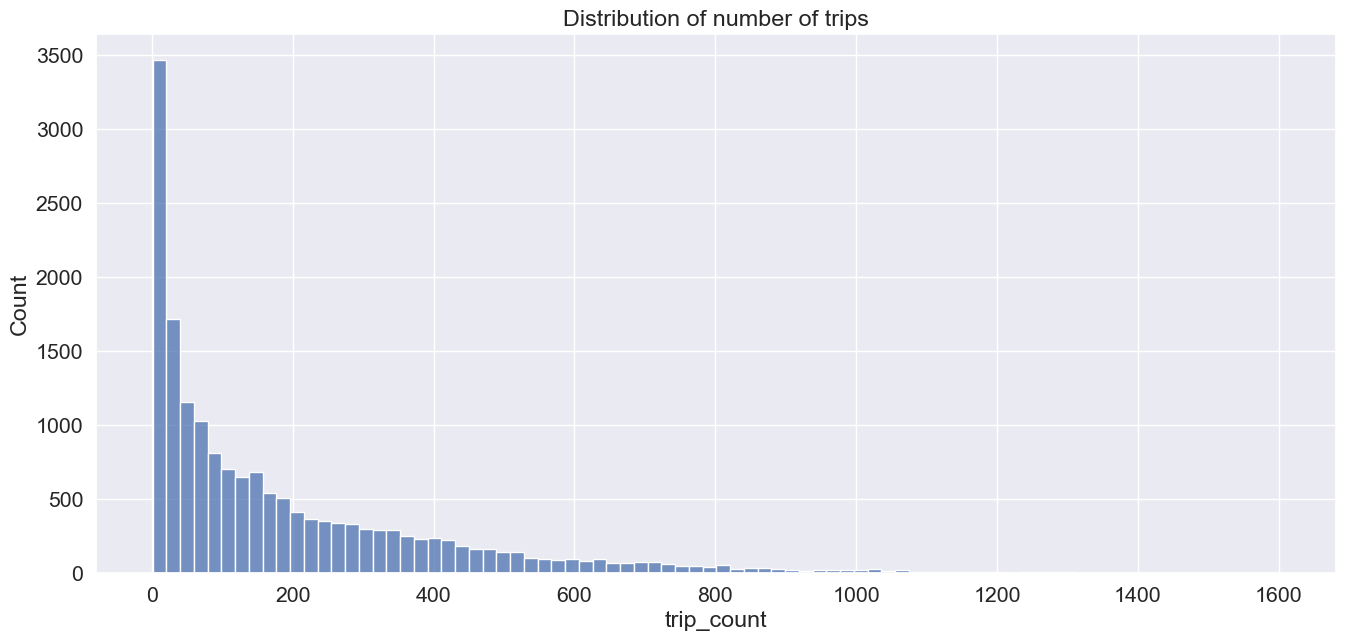

In [27]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.histplot(data=result, x='trip_count')
plt.title("Distribution of number of trips")
plt.show()

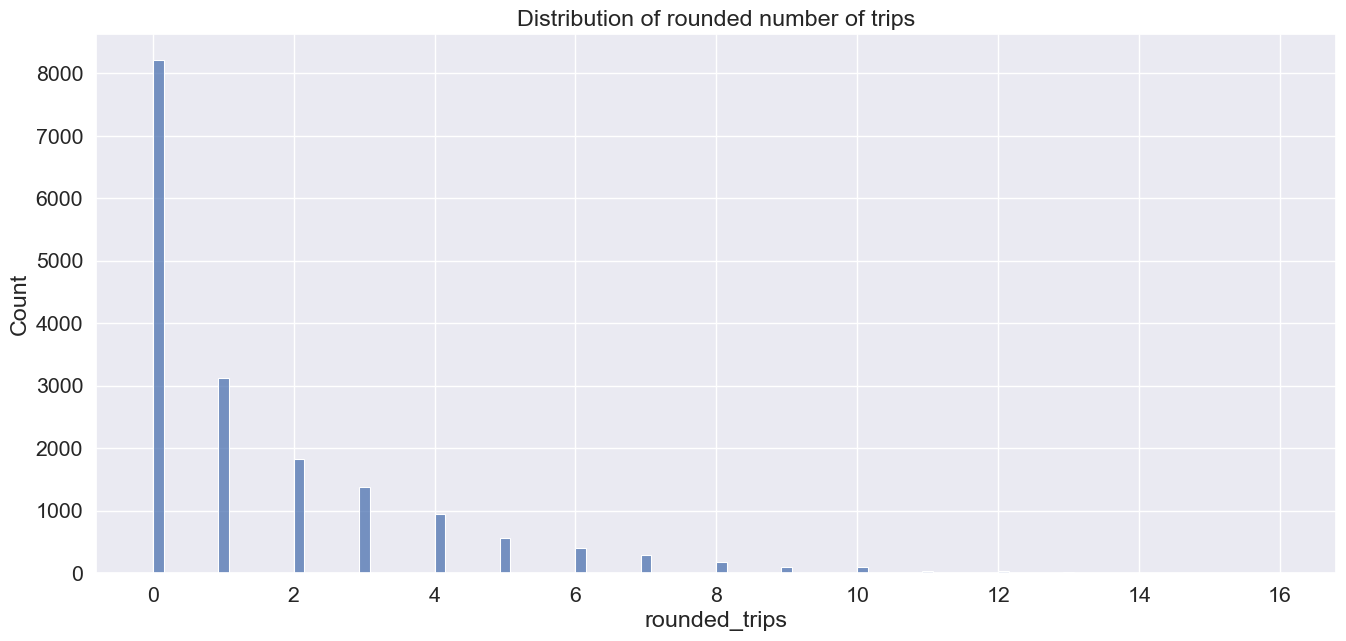

In [28]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.histplot(data=result, x='rounded_trips')
plt.title("Distribution of rounded number of trips")
plt.show()

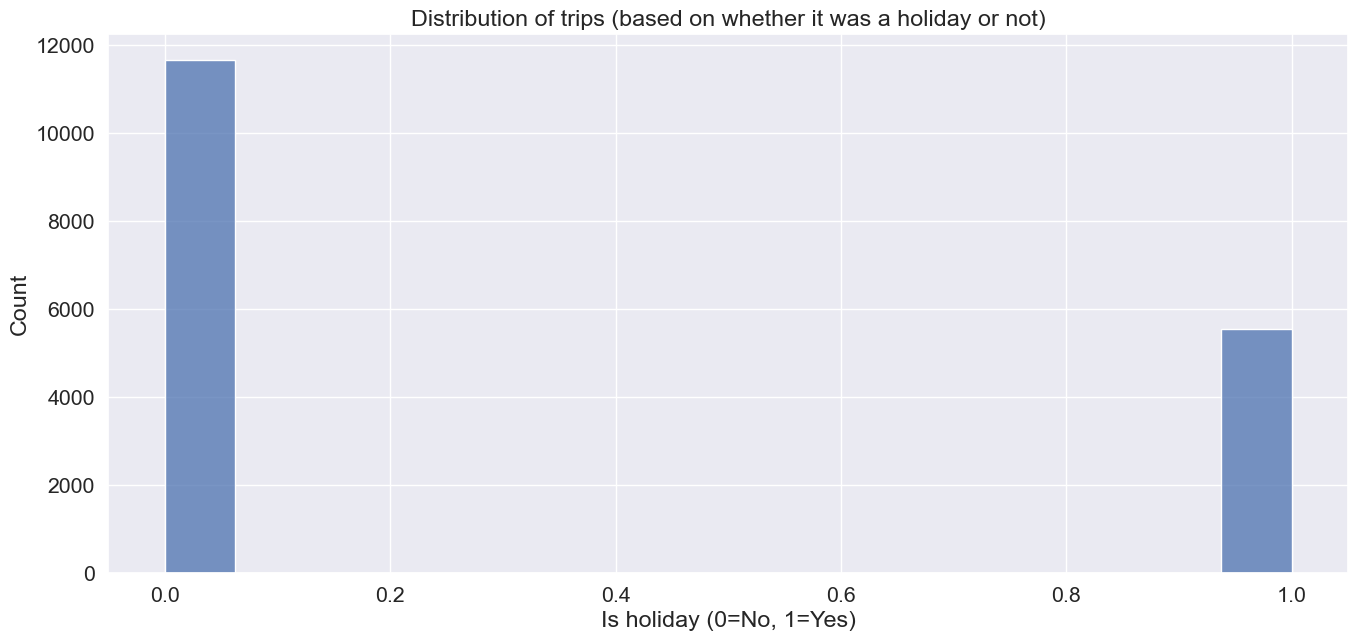

In [29]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.histplot(data=result, x='is_holiday', kde=False)
plt.title("Distribution of trips (based on whether it was a holiday or not)")
plt.xlabel("Is holiday (0=No, 1=Yes)")
plt.show()

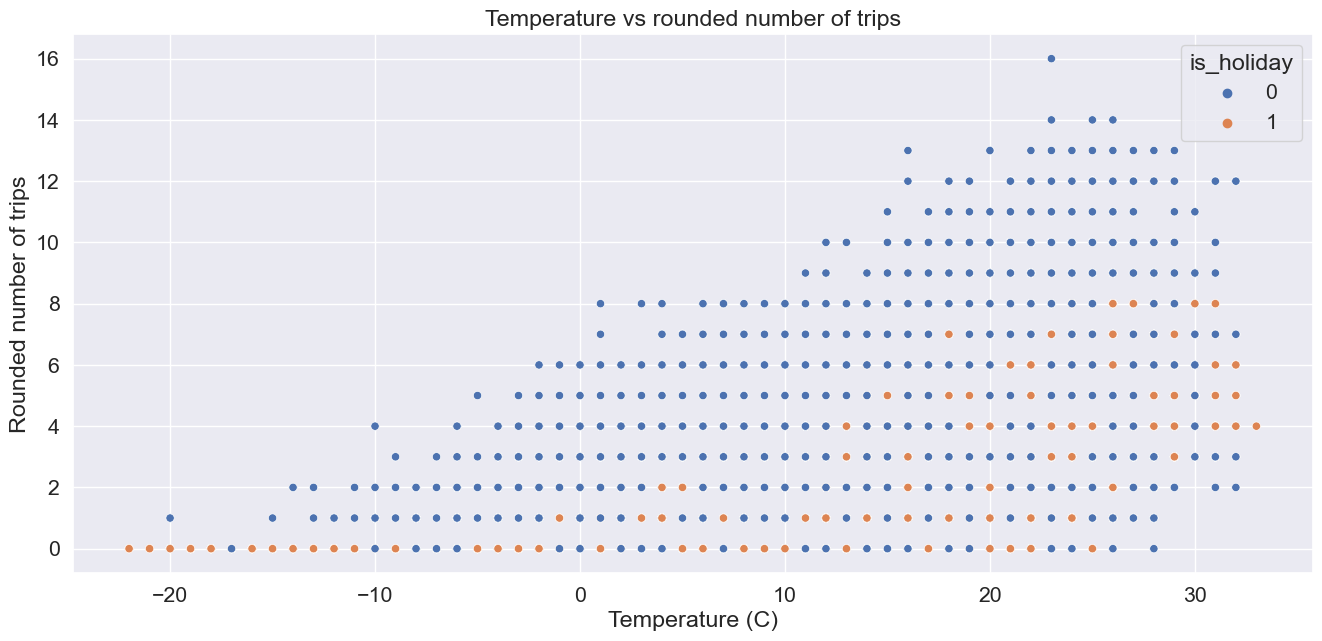

In [30]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.scatterplot(data=result, 
                x= 'temp_c', 
                y='rounded_trips', 
                hue='is_holiday')
plt.xlabel("Temperature (C)")
plt.ylabel("Rounded number of trips")
plt.title("Temperature vs rounded number of trips")
plt.show()

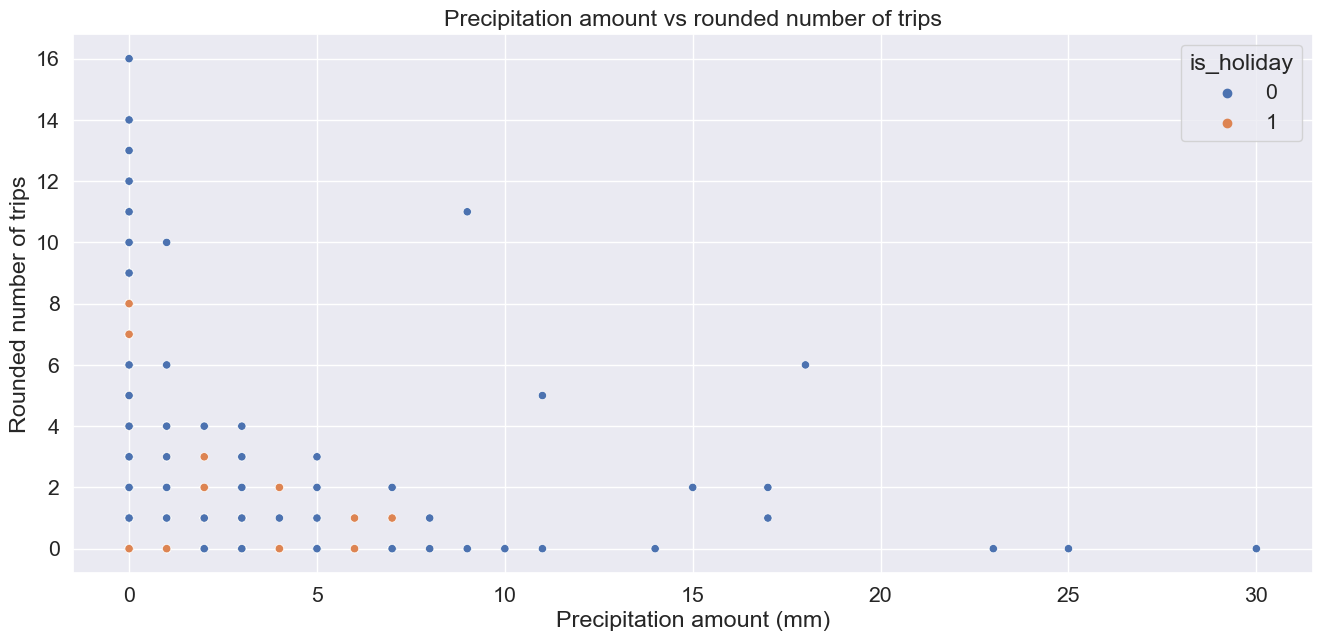

In [31]:
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.scatterplot(data=result, 
                x= 'precip_amount_mm', 
                y='rounded_trips', 
                hue='is_holiday')
plt.xlabel("Precipitation amount (mm)")
plt.ylabel("Rounded number of trips")

plt.title("Precipitation amount vs rounded number of trips")
plt.show()

## Set up classification model

We're going to create a binary column `low_trip_count` to account for days in which there were less than 200 trips, or more than 200 trips.

Our goal will be to classify whether certain days will have less than 200 trips (`low_trip_count==True`) or if they have 200 trips or more (`low_trip_count==False`).

## Pre-requisites

In [32]:
!pip install sklearn-evaluation scikit-learn --quiet


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn_evaluation import plot, table

## Set up variables, split data

In [34]:
# Create column
result['low_trip_count'] = np.where(result['trip_count']<200, True, False)

# Set up X and y variables
X = result[['trip_hour', 'trip_day',
               'trip_month', 'trip_year', 'trip_month_week',
               'trip_week_day', 'temp_c', 'precip_amount_mm', 'is_holiday']]
y = result['low_trip_count']

# Split data - notice class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y,
                                                    random_state=42)

## Initialize model

In [35]:
ln = RandomForestClassifier()

ln.fit(X_train, y_train)
y_pred = ln.predict(X_test)

## Evaluate model

In [36]:
print("Acc on test data: {:,.3f}".format(ln.score(X_test, y_test)))
print(classification_report(y_pred=y_pred, y_true=y_test))

Acc on test data: 0.947
              precision    recall  f1-score   support

       False       0.92      0.93      0.92      1175
        True       0.96      0.96      0.96      2267

    accuracy                           0.95      3442
   macro avg       0.94      0.94      0.94      3442
weighted avg       0.95      0.95      0.95      3442



## Evaluate model

<Figure size 2000x700 with 0 Axes>

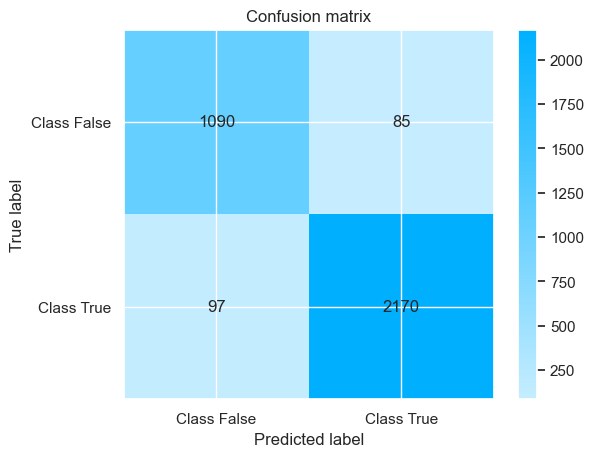

In [37]:
plt.figure(figsize=(20,7))
sns.set(font_scale=1)
plot.confusion_matrix(y_test, y_pred);
plt.show()

<Axes: title={'center': 'Feature importances'}>

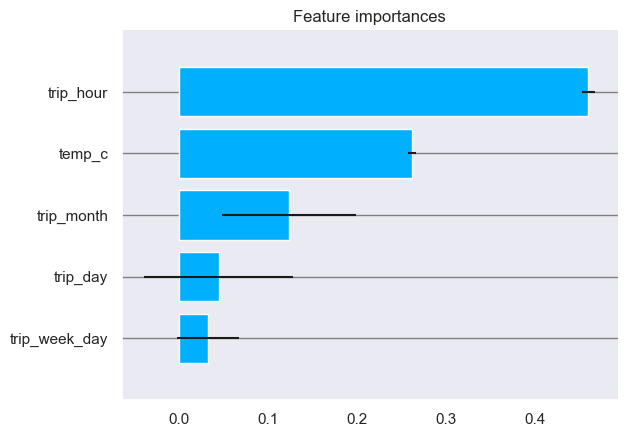

In [38]:
plot.feature_importances(ln, top_n=5, feature_names=list(ln.feature_names_in_))


## Key takeaways

⚡ We used the Jupyter notebook extension `JupySQL` to enable access to a Redshift instance through credentials and a host URL

⚡ With `JupySQL`, we were able to customize the default behaviour of the query results to be of format `pandas` (or `polars`)

⚡ Furthermore, with `JupySQL` we were able to create each of the tables from an S3 bucket, verify that the tables were loaded and get summary stats

⚡ We were then able to use our query results in `pandas` format, and leverage techniques in classic supervised learning to classify whether a given day will have low number of trips (less than 200) or higher. 



## Find us on GitHub



<center>
    <h1>
Learn more about JupySQL 
    </h1>
    <h2>
 🐙 https://github.com/ploomber/jupysql 🐙
    </h2>
    <h3 font-family="courier">
    pip install jupysql
        <h3>
</center>